# Practica 1: Aprendizaje automatico
## Parte 2: Clasificación

Grupo Lab: 06<br>
Daniel Alfaro Miranda e Ismail Azizi Gonzalez

## Conjunto de datos: Cancer de pecho

El conjunto describe a 569 pacientes de cáncer de mama con 30 variables (10 propiedades, cada una con media. desviación típica y valores extremos) para predecir si el tumor es benigno o maligno.

In [382]:
from sklearn.datasets import load_breast_cancer
breast = load_breast_cancer()

In [383]:
import pandas as pd
df = pd.DataFrame(data=breast['data'], columns=breast['feature_names']) 
df['result'] = breast['target']

In [384]:
mean = filter(lambda item: "mean" in item , breast['feature_names'])
medias = []
for item in mean:
    medias.append(item)
error = filter(lambda item: "error" in item , breast['feature_names'])
desv = []
for item in error:
    desv.append(item)
worst = filter(lambda item: "worst" in item , breast['feature_names'])
extremos = []
for item in worst:
    extremos.append(item)

## Descripción del conjunto de datos

### Reprensentación de los valores medios
Los valores medios nos solapan los datos en prácticamente todas las características, con lo cual no es bueno para sacar conclusiones y desarrollar un clasificador a partir de estos datos. En principio le daremos poca importancia en este caso, ya que nos puede llevar a conclusiones erróneas a traves de un sobreaprendizaje de esta muestra en concreto.

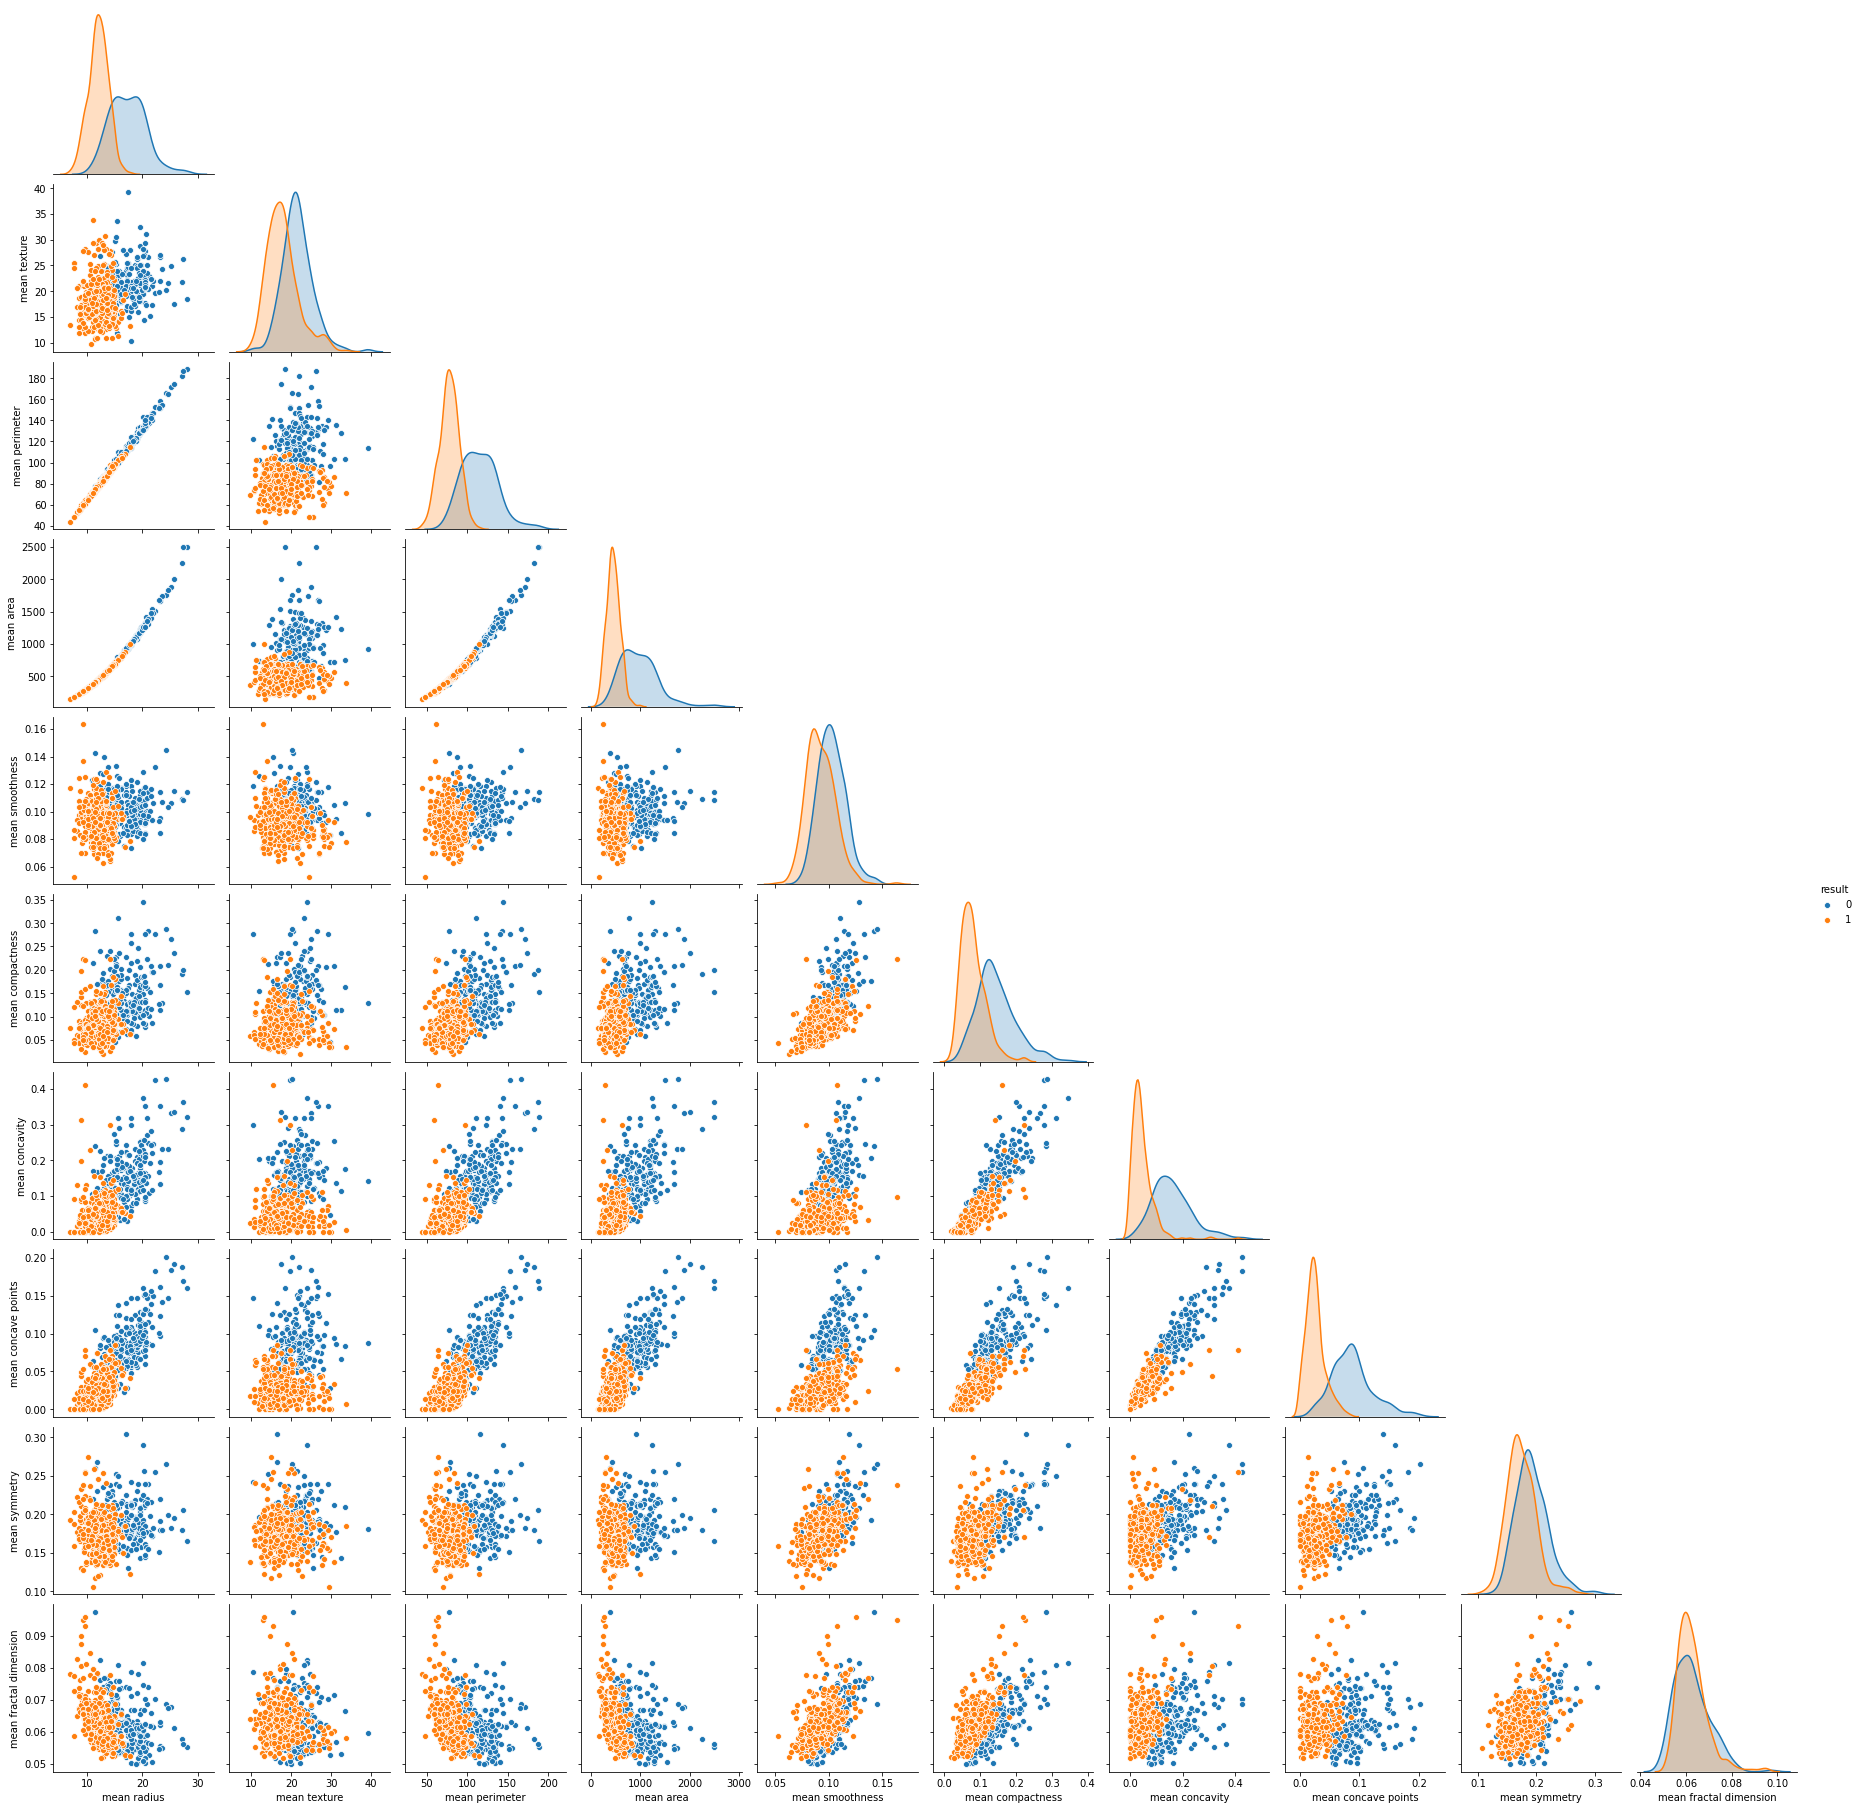

In [385]:
import seaborn as sns
graph = sns.pairplot(df, corner = True, hue="result", vars = medias)

### Representación de los valores extremos
Los valores extremos van a ser la medida más útil en este caso, ya que es la que más diferencia el conjunto de datos según su valor. Aunque haya características que no nos sirvan, ya que hay un solapamiento alto (por ejemplo symmetry o smoothness) en otras características notamos que los valores difieren mucho según si el tumor es maligno o benigno (por ejemplo area, perimeter, concavity o concave points). Si bien hay intersección entre los conjuntos de puntos incluso para las métrica que consideramos buenas, el solapamiento en relación al conjunto total de valores no es tan significativo.

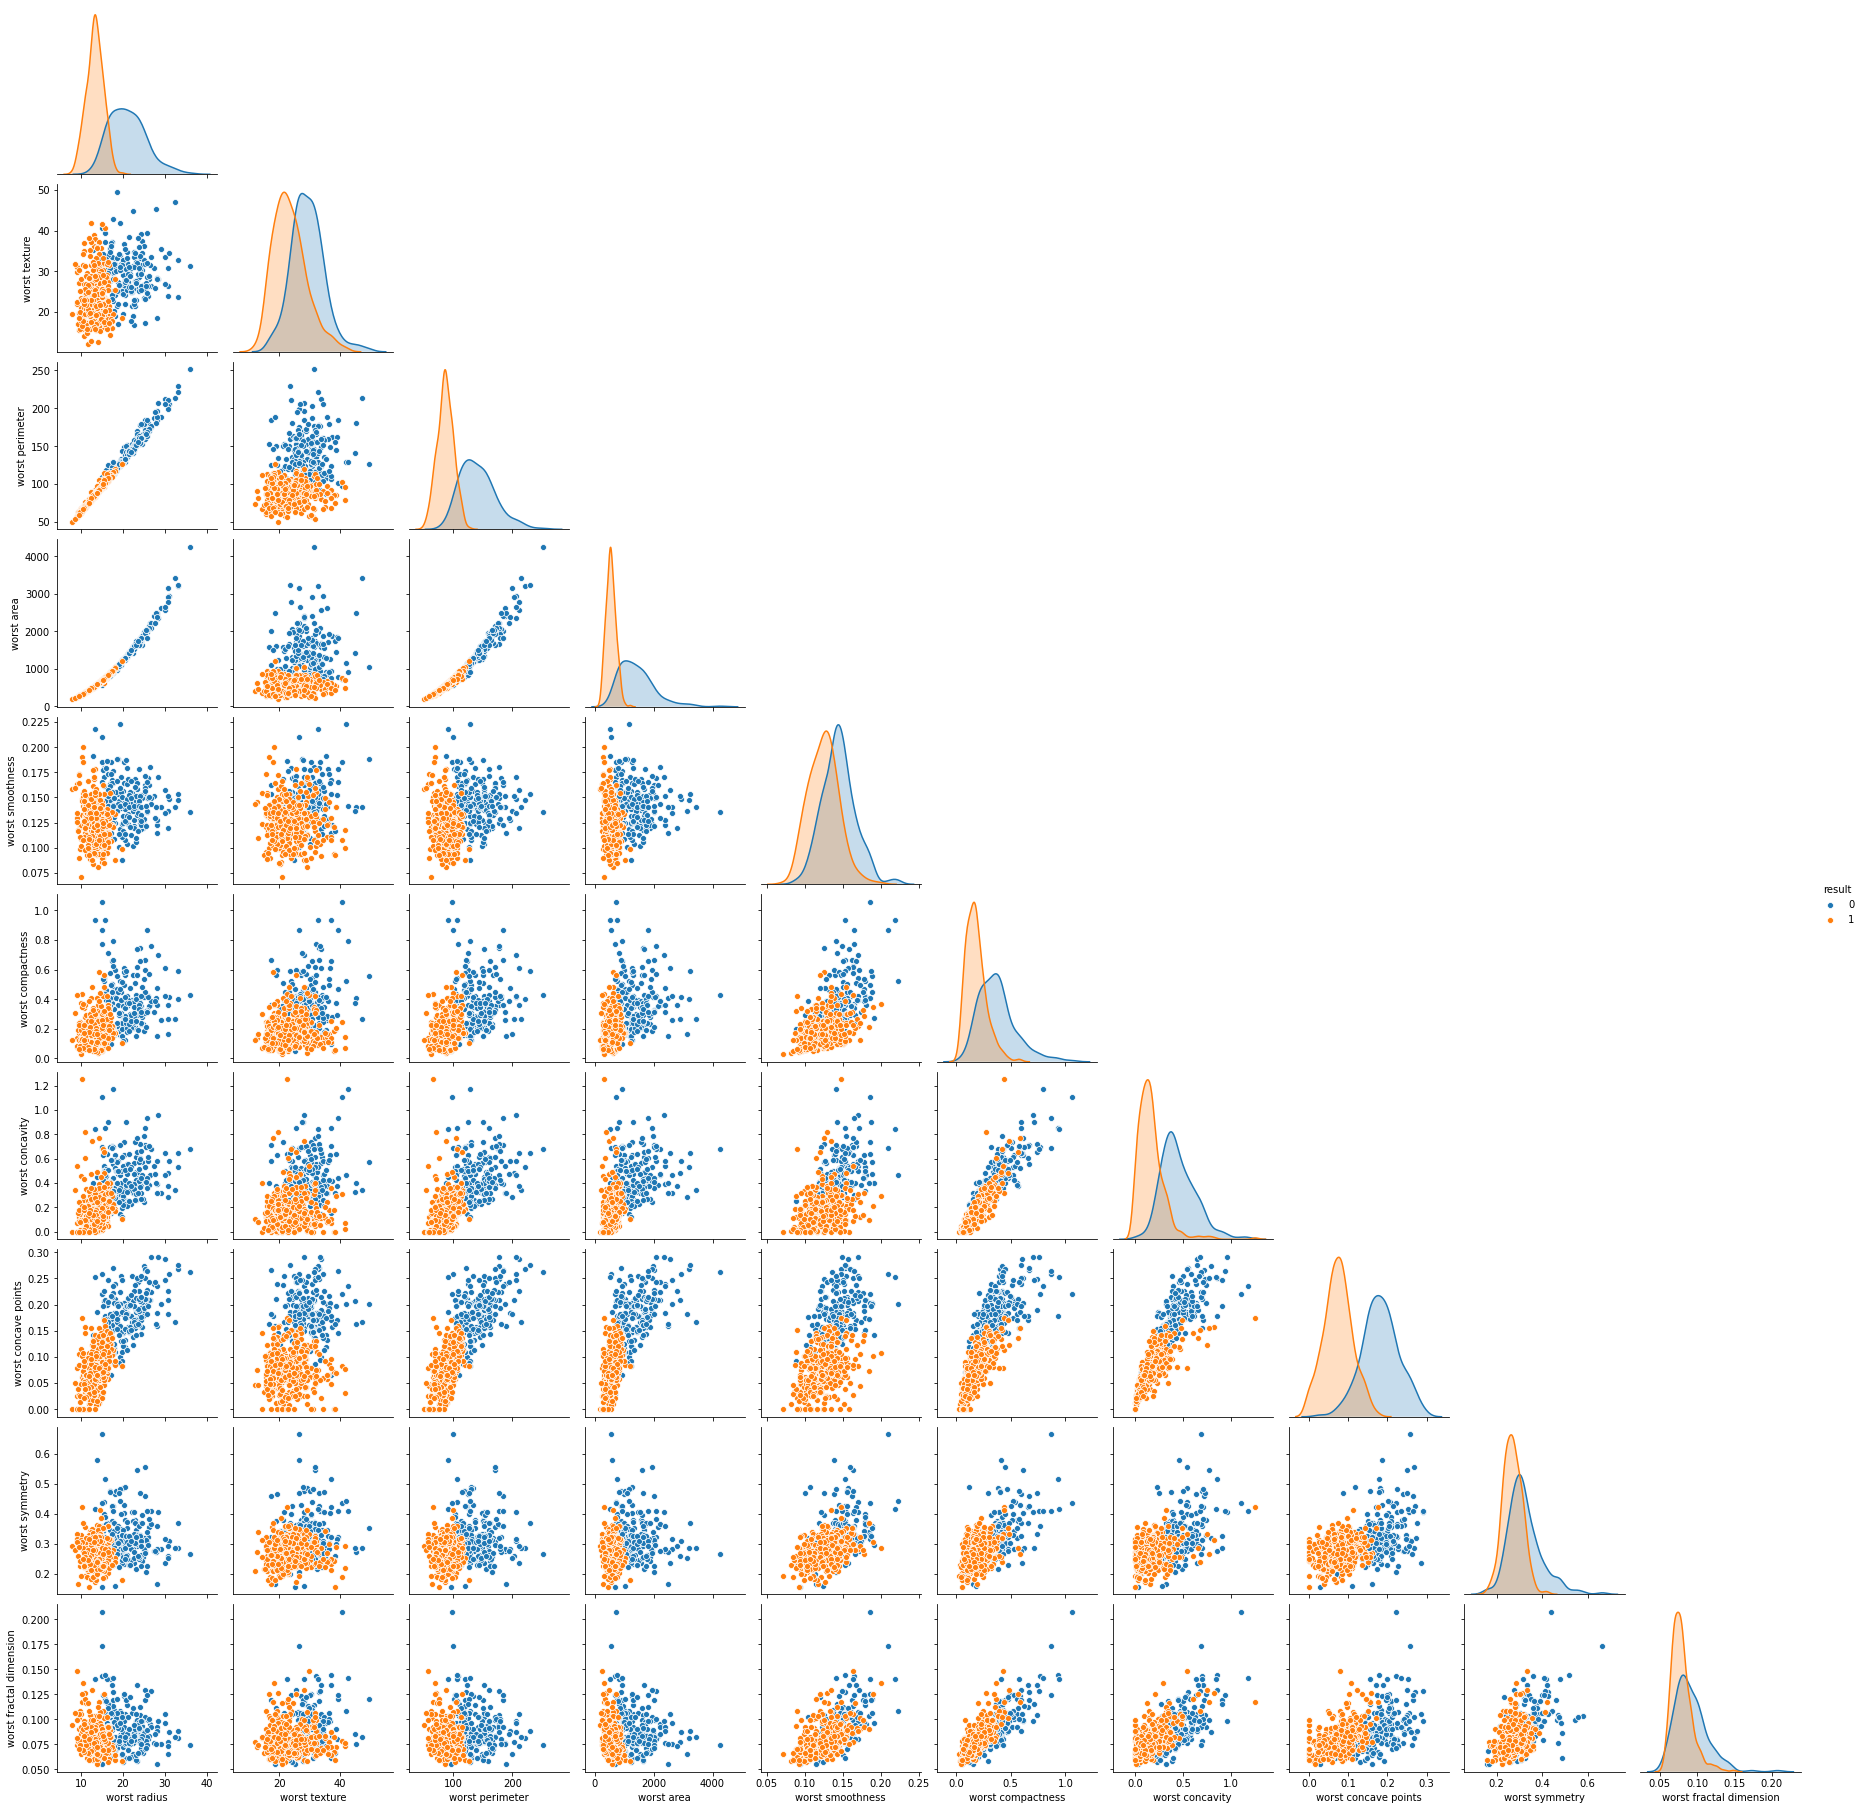

In [386]:
graph = sns.pairplot(df, corner = True, hue="result", vars = extremos)

### Representación de la desviación típica
La desviación típica, al igual que los valores medios se solapan bastante, así que en principio no nos valdrá demasiado para generalizar el conjunto de datos. Aún así podría llegar a usarse alguna caracterísitca (como por ejemplo "perimeter error")

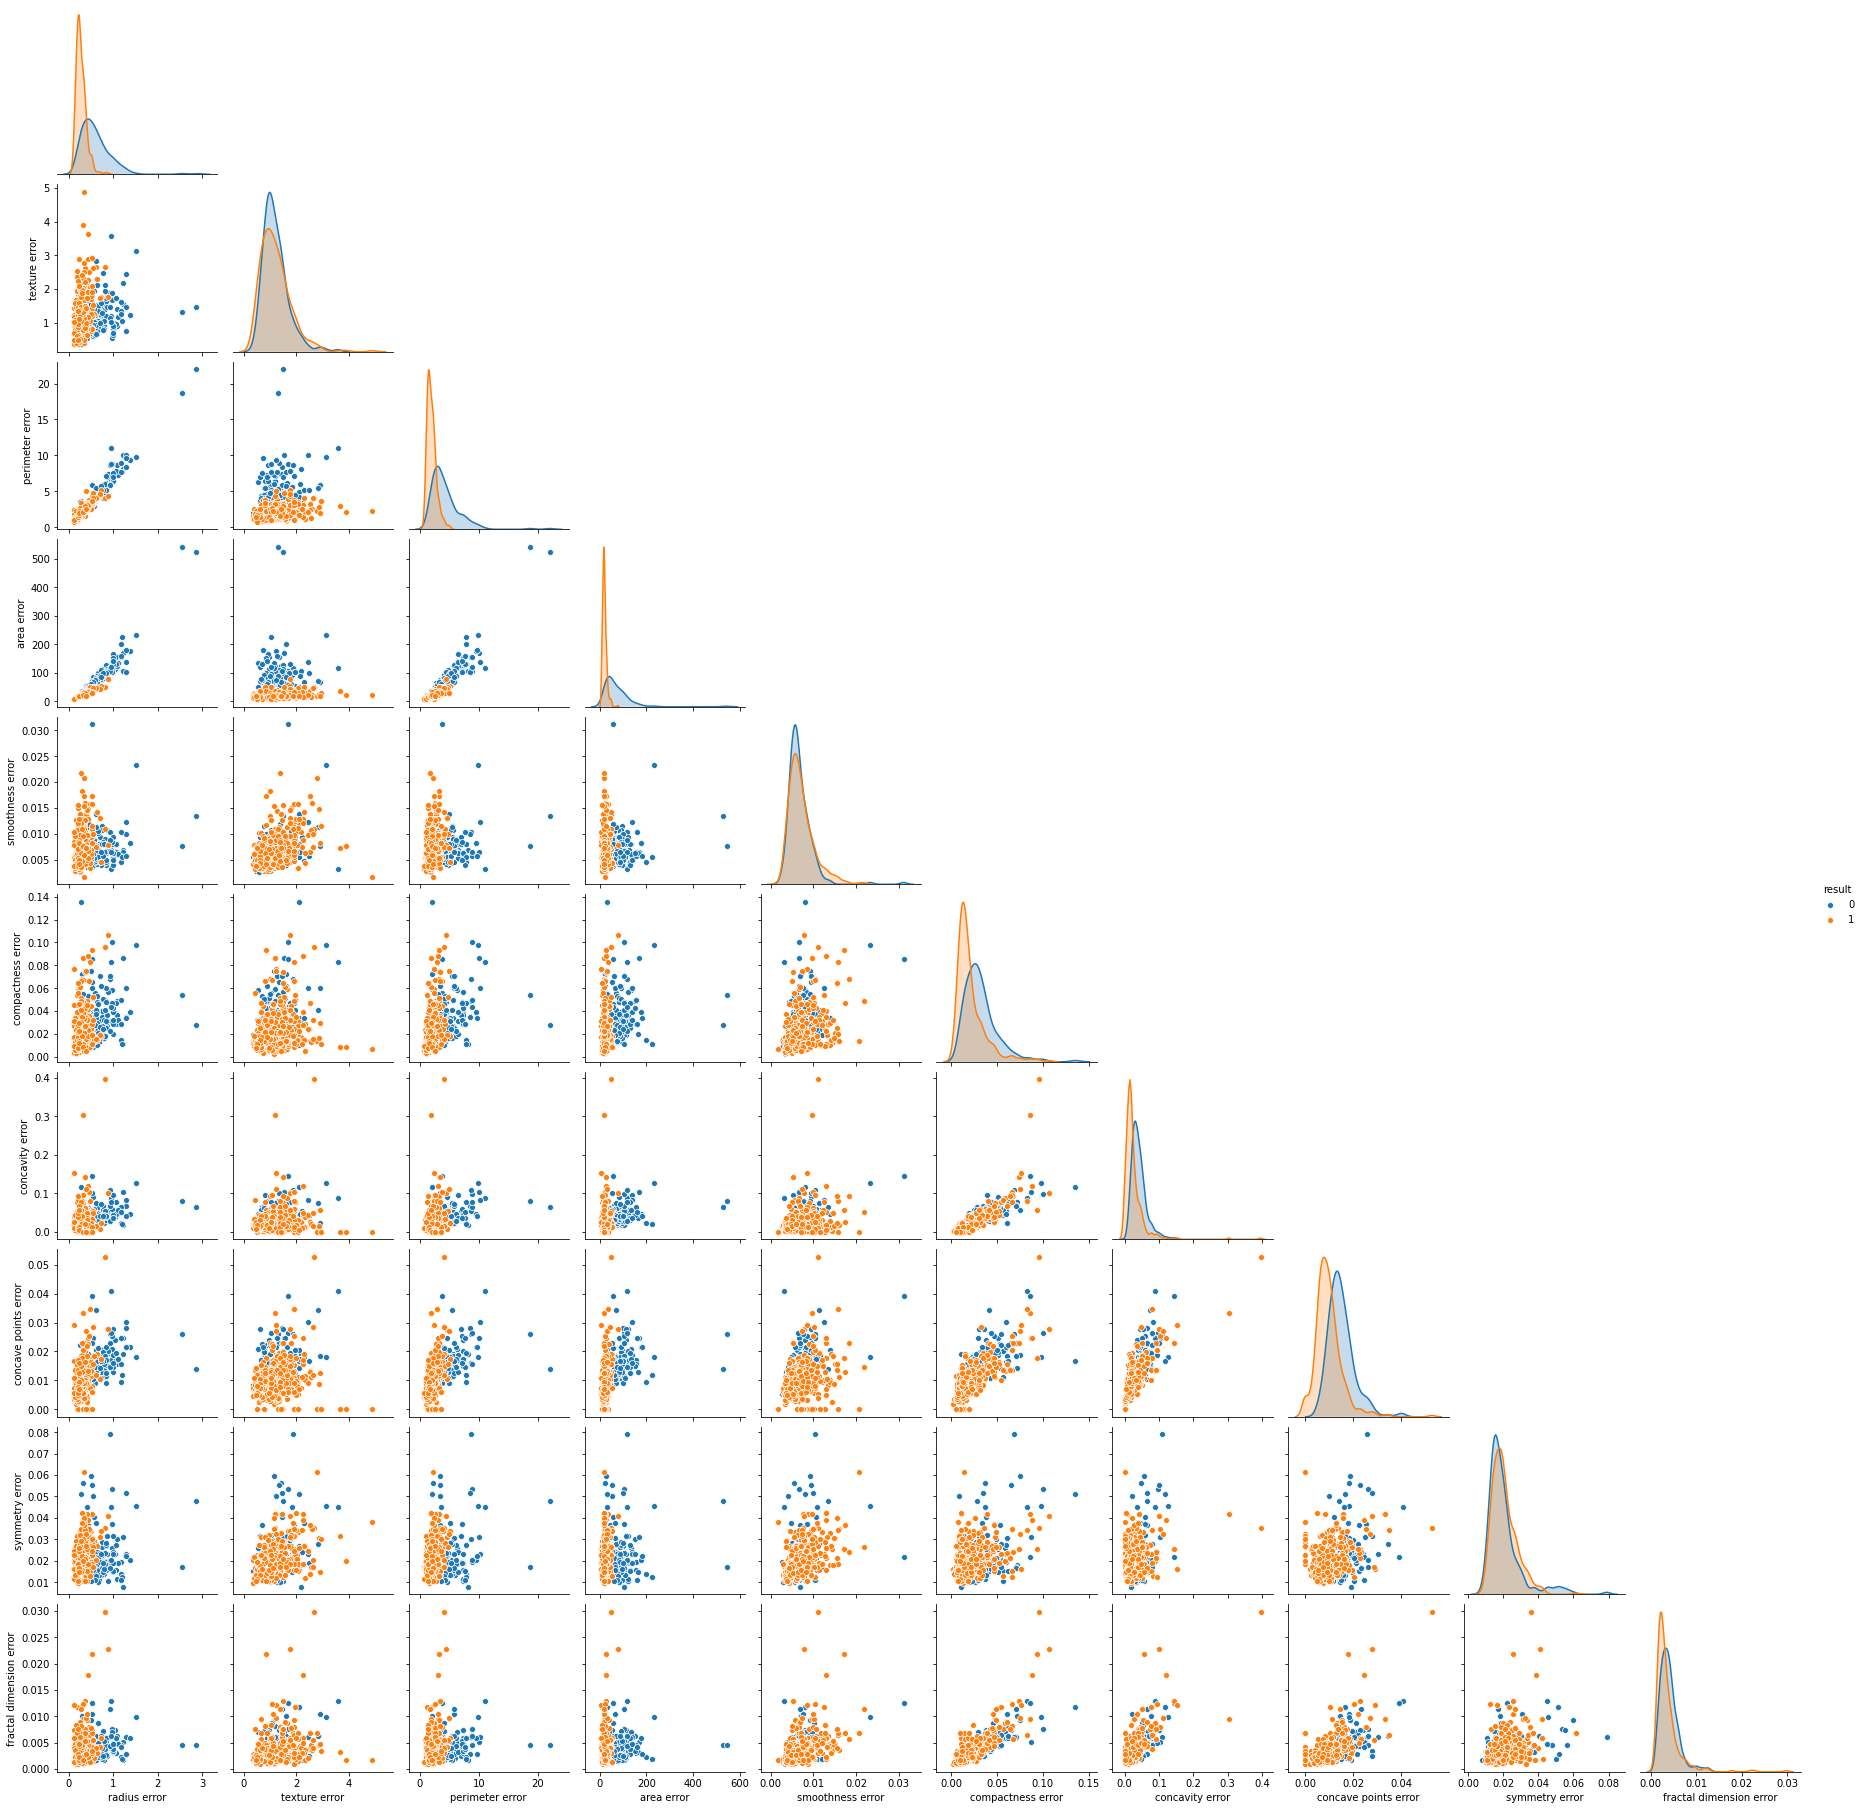

In [387]:
graph = sns.pairplot(df, corner = True, hue="result", vars = desv)

## Árbol de Decisión
Realizamos el árbol de decisión mediante la librería scikit-learn utilizando la misma semilla de aleatoreidad para la consistencia de los datos y utilizando la entropía como criterio de clasificación.<br>
Dada la naturaleza de los árboles de decisión, que nos dividen la muestra de manera que los datos se separen lo más rápido posible, no es necesario reescalar los datos, ya que el árbol de decisión cogerá primero las características que más impacten para separar la mayor parte de individuos, con lo cual los valores no necesitan estar normalizados, como por ejemplo en K-nn, en el que un valor extremo puede influir mucho en el resultado final (en este caso el valor extremo no tendría prioridad para separarse y se tendría en cuenta mucho más adelante, para realizar las últimas separaciones).

In [390]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(criterion = "entropy", random_state = 333)
clf = clf.fit(breast.data, breast.target)

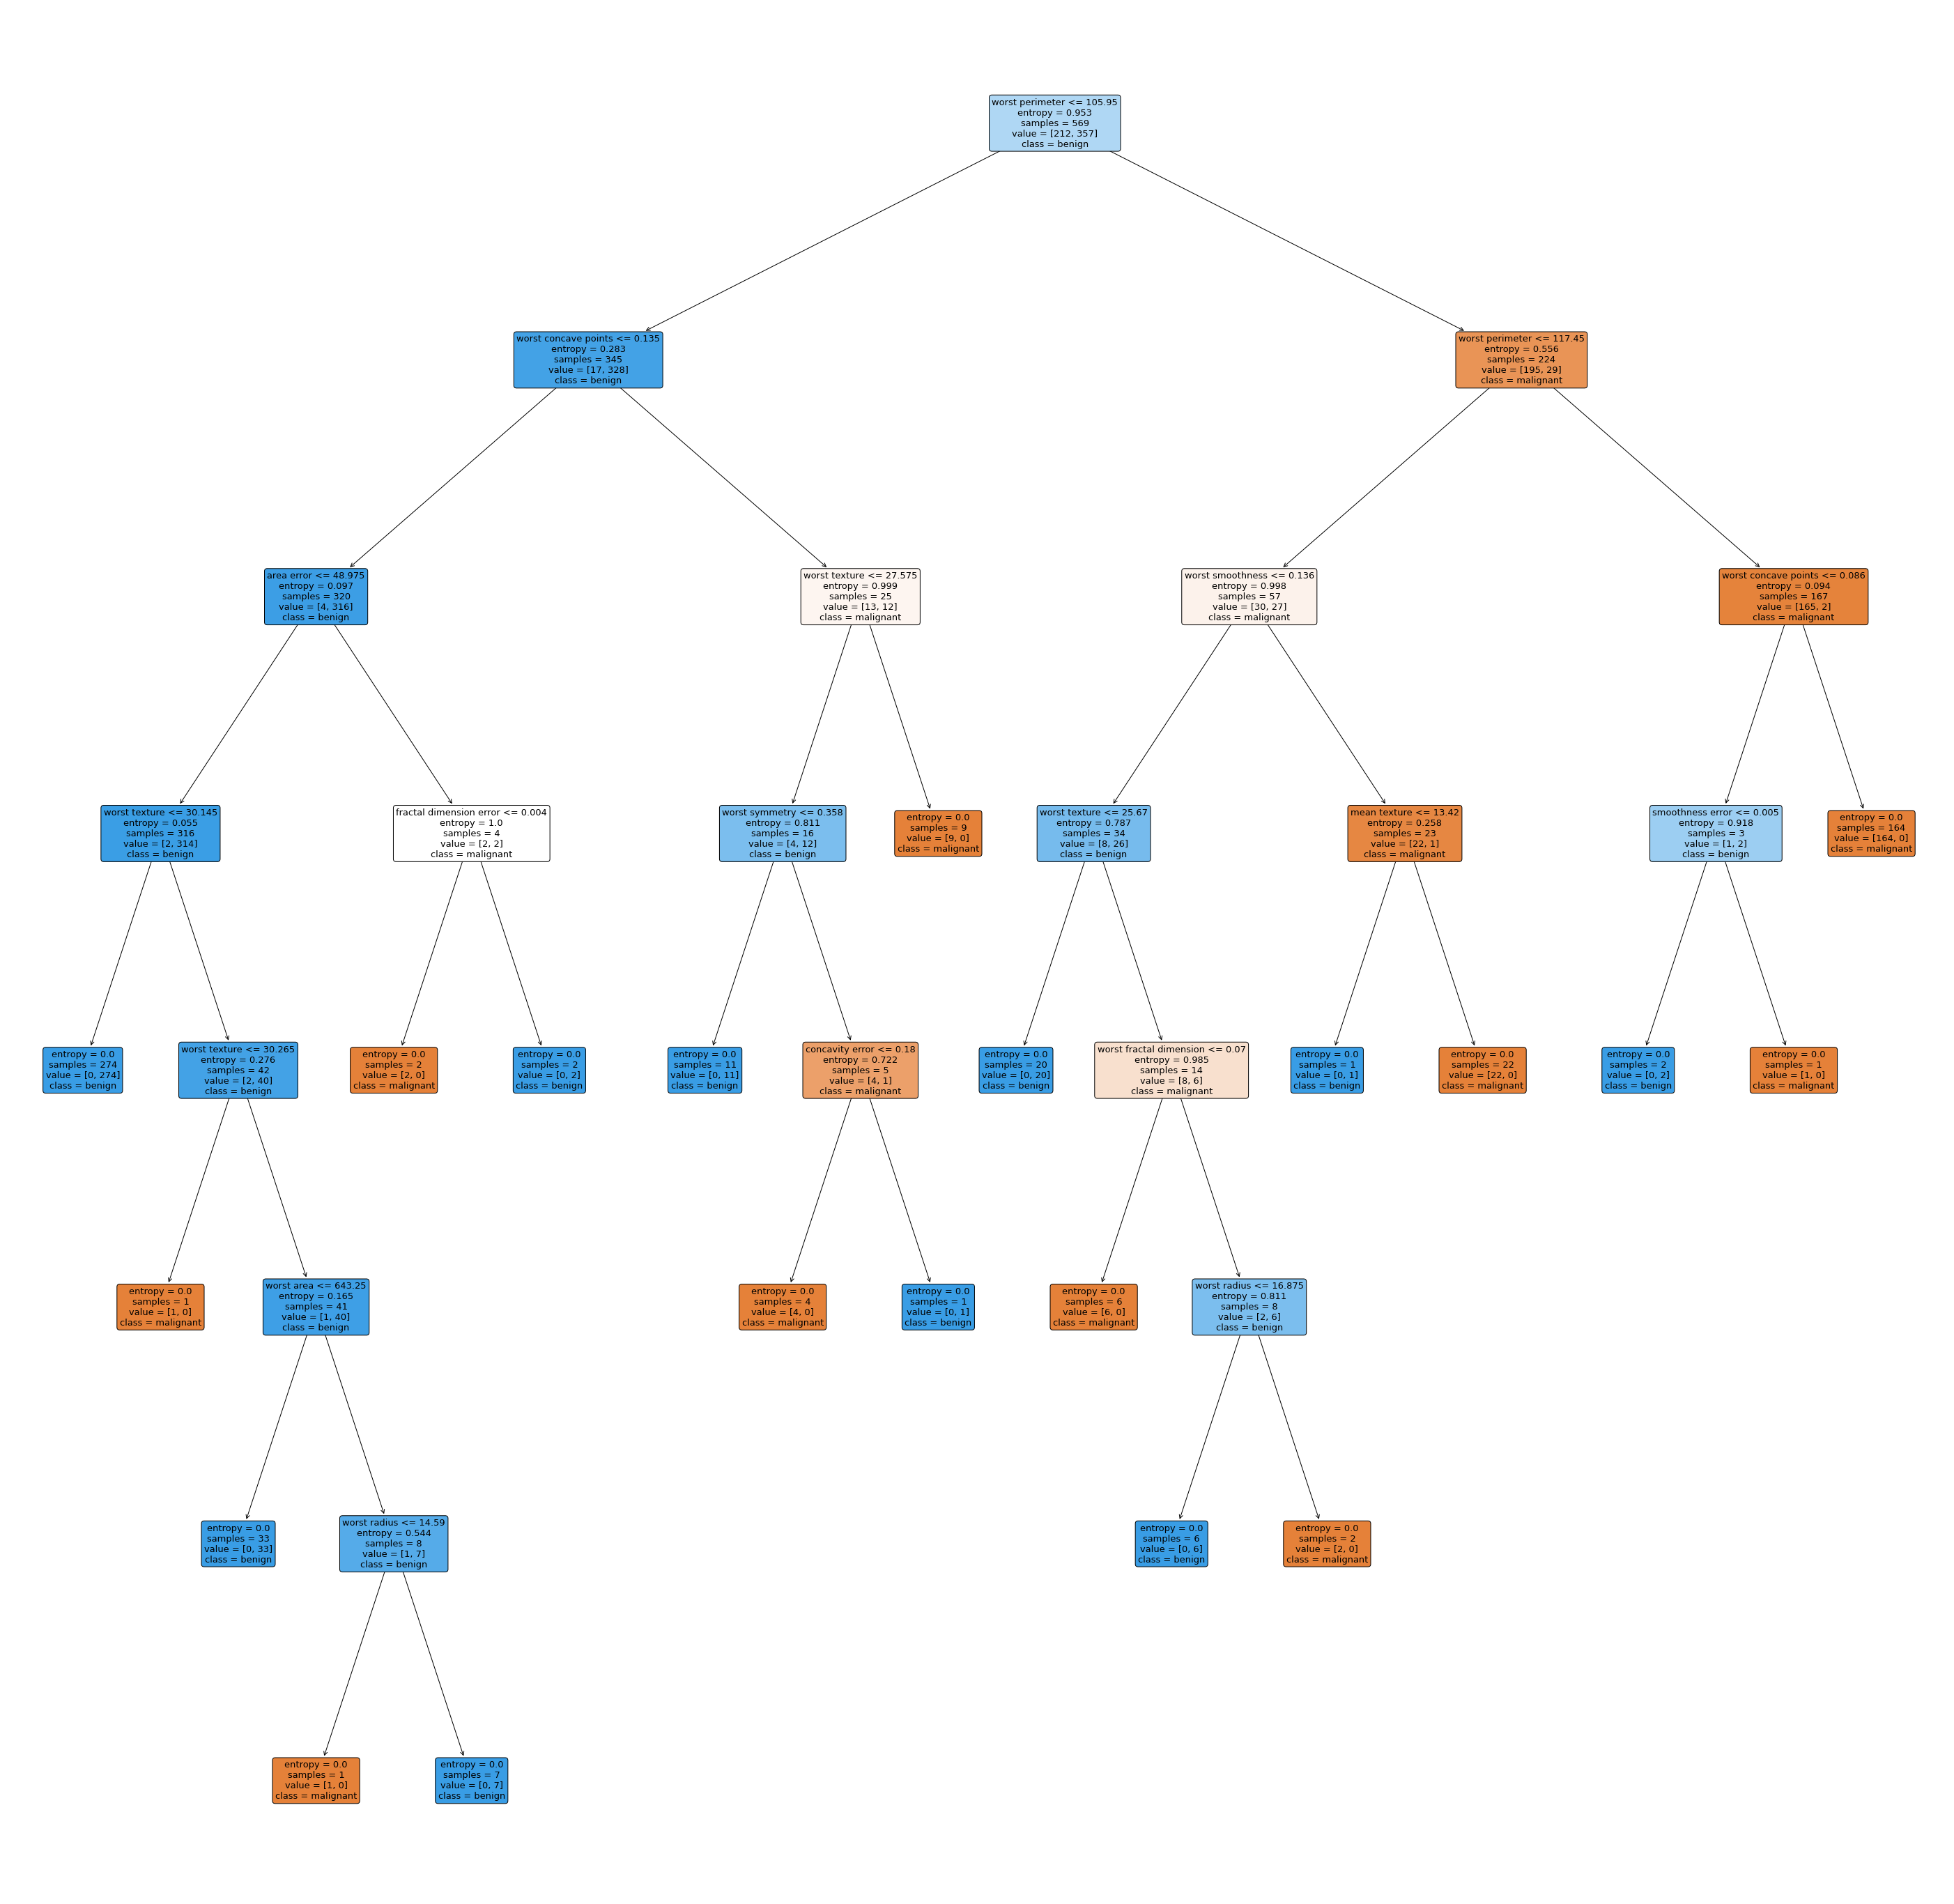

In [391]:
plt.figure(figsize=(50,50))
plot_tree(clf, filled=True, feature_names=breast.feature_names, class_names=breast.target_names, rounded=True)
plt.show()

Como podemos ver, el árbol de decisión nos separa todos los datos completamente para esta muestra, pero ultilizarlo como modelo para un caso cualquiera no es lo óptimo, ya que estaremos discriminando individuos concretos por características que pueden no tener que ver y haber dado la casualidad de que difieren esos individuos pero no ser extrapolable a otro conjunto de individuos más general.

## Entrenamiento y test del árbol de decisión
Tomamos el 70% de datos para entrenamiento y el otro 30% para la validación.

In [392]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(breast.data, breast.target, test_size=0.3, random_state=333)

clf = DecisionTreeClassifier(criterion="entropy", random_state=333)
clf = clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
train_accuracy, test_accuracy

(1.0, 0.9181286549707602)

Como vemos el árbol aprende el conjunto de datos perfectamente (100%) y en la fase de test tiene una precisión del 91.8%. Estos resultados pueden parecer buenos, pero estamos sobreaprendiendo las características de este conjunto de datos en concreto para separarlo perfectamente, las cuales probablemente no sean aplicables a otra muestra con otros individuos

Vamos a realizar otro árbol de decisión, pero en este caso limitaremos el número de individuos mínimo para crear otro nodo nuevo (15).

In [393]:
clf = DecisionTreeClassifier(criterion="entropy", min_samples_split=15, random_state=333)
clf = clf.fit(X_train, y_train)

train_accuracy = clf.score(X_train, y_train)
test_accuracy = clf.score(X_test, y_test)
train_accuracy, test_accuracy

(0.9773869346733668, 0.9239766081871345)

Podemos comprobar que el árbol de decisión es mejor, ya que ha obtenido un mejor accuracy en cuanto a la fase de test, pero más importante, ha aprendido los datos menos que el anterior (97.7%), con lo cual ha generalizado más y no se ha centrado tanto en sacar conclusiones perfectas para una muestra concreta y se enfoca más en separar conjuntos de datos más grandes y deja de lado conjuntos de datos pequeños que necesitan de características poco relevantes para ser separados

Vamos a realizar la validación en base a la altura del árbol, con unas muestras mínimas (15) para expandir un nodo.

In [396]:
from sklearn.model_selection import cross_validate
import numpy as np

train_accuracy = []
test_accuracy = []

max_depths = range(1, 9)
for md in max_depths: 

    clf = DecisionTreeClassifier(criterion="entropy", max_depth=md, min_samples_split=15)
    scores = cross_validate(clf, breast.data, breast.target, scoring='accuracy', cv=15, return_train_score=True)
    
    train_accuracy.append(np.mean(scores['train_score']))
    test_accuracy.append(np.mean(scores['test_score']))

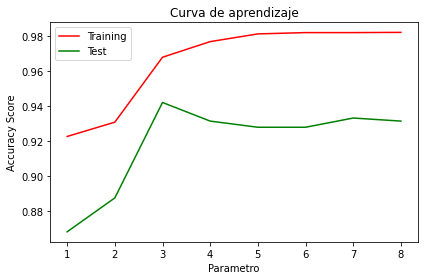

In [397]:
plt.plot(max_depths, train_accuracy, color="r",  label="Training")
plt.plot(max_depths, test_accuracy, color="g", label="Test")

plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()   

Vemos que para altura un árbol de altura 3 tenemos el accuracy más alto y el aprendizaje de la muestra es menor que para valores mayores que 3. Para valores menores que tres el accuracy en el entrenamiento es más bajo, pero también hay una disminución a tener en cuenta en el accuracy de la validación, con lo cual nuestro valor óptimo para la altura será 3.

## Árbol de decisión óptimo
Ahora que ya hemos fijado que la áltura óptima del árbol debe ser 3, volvemos a generar el árbol con los parámetros que nos ha dado la validación.

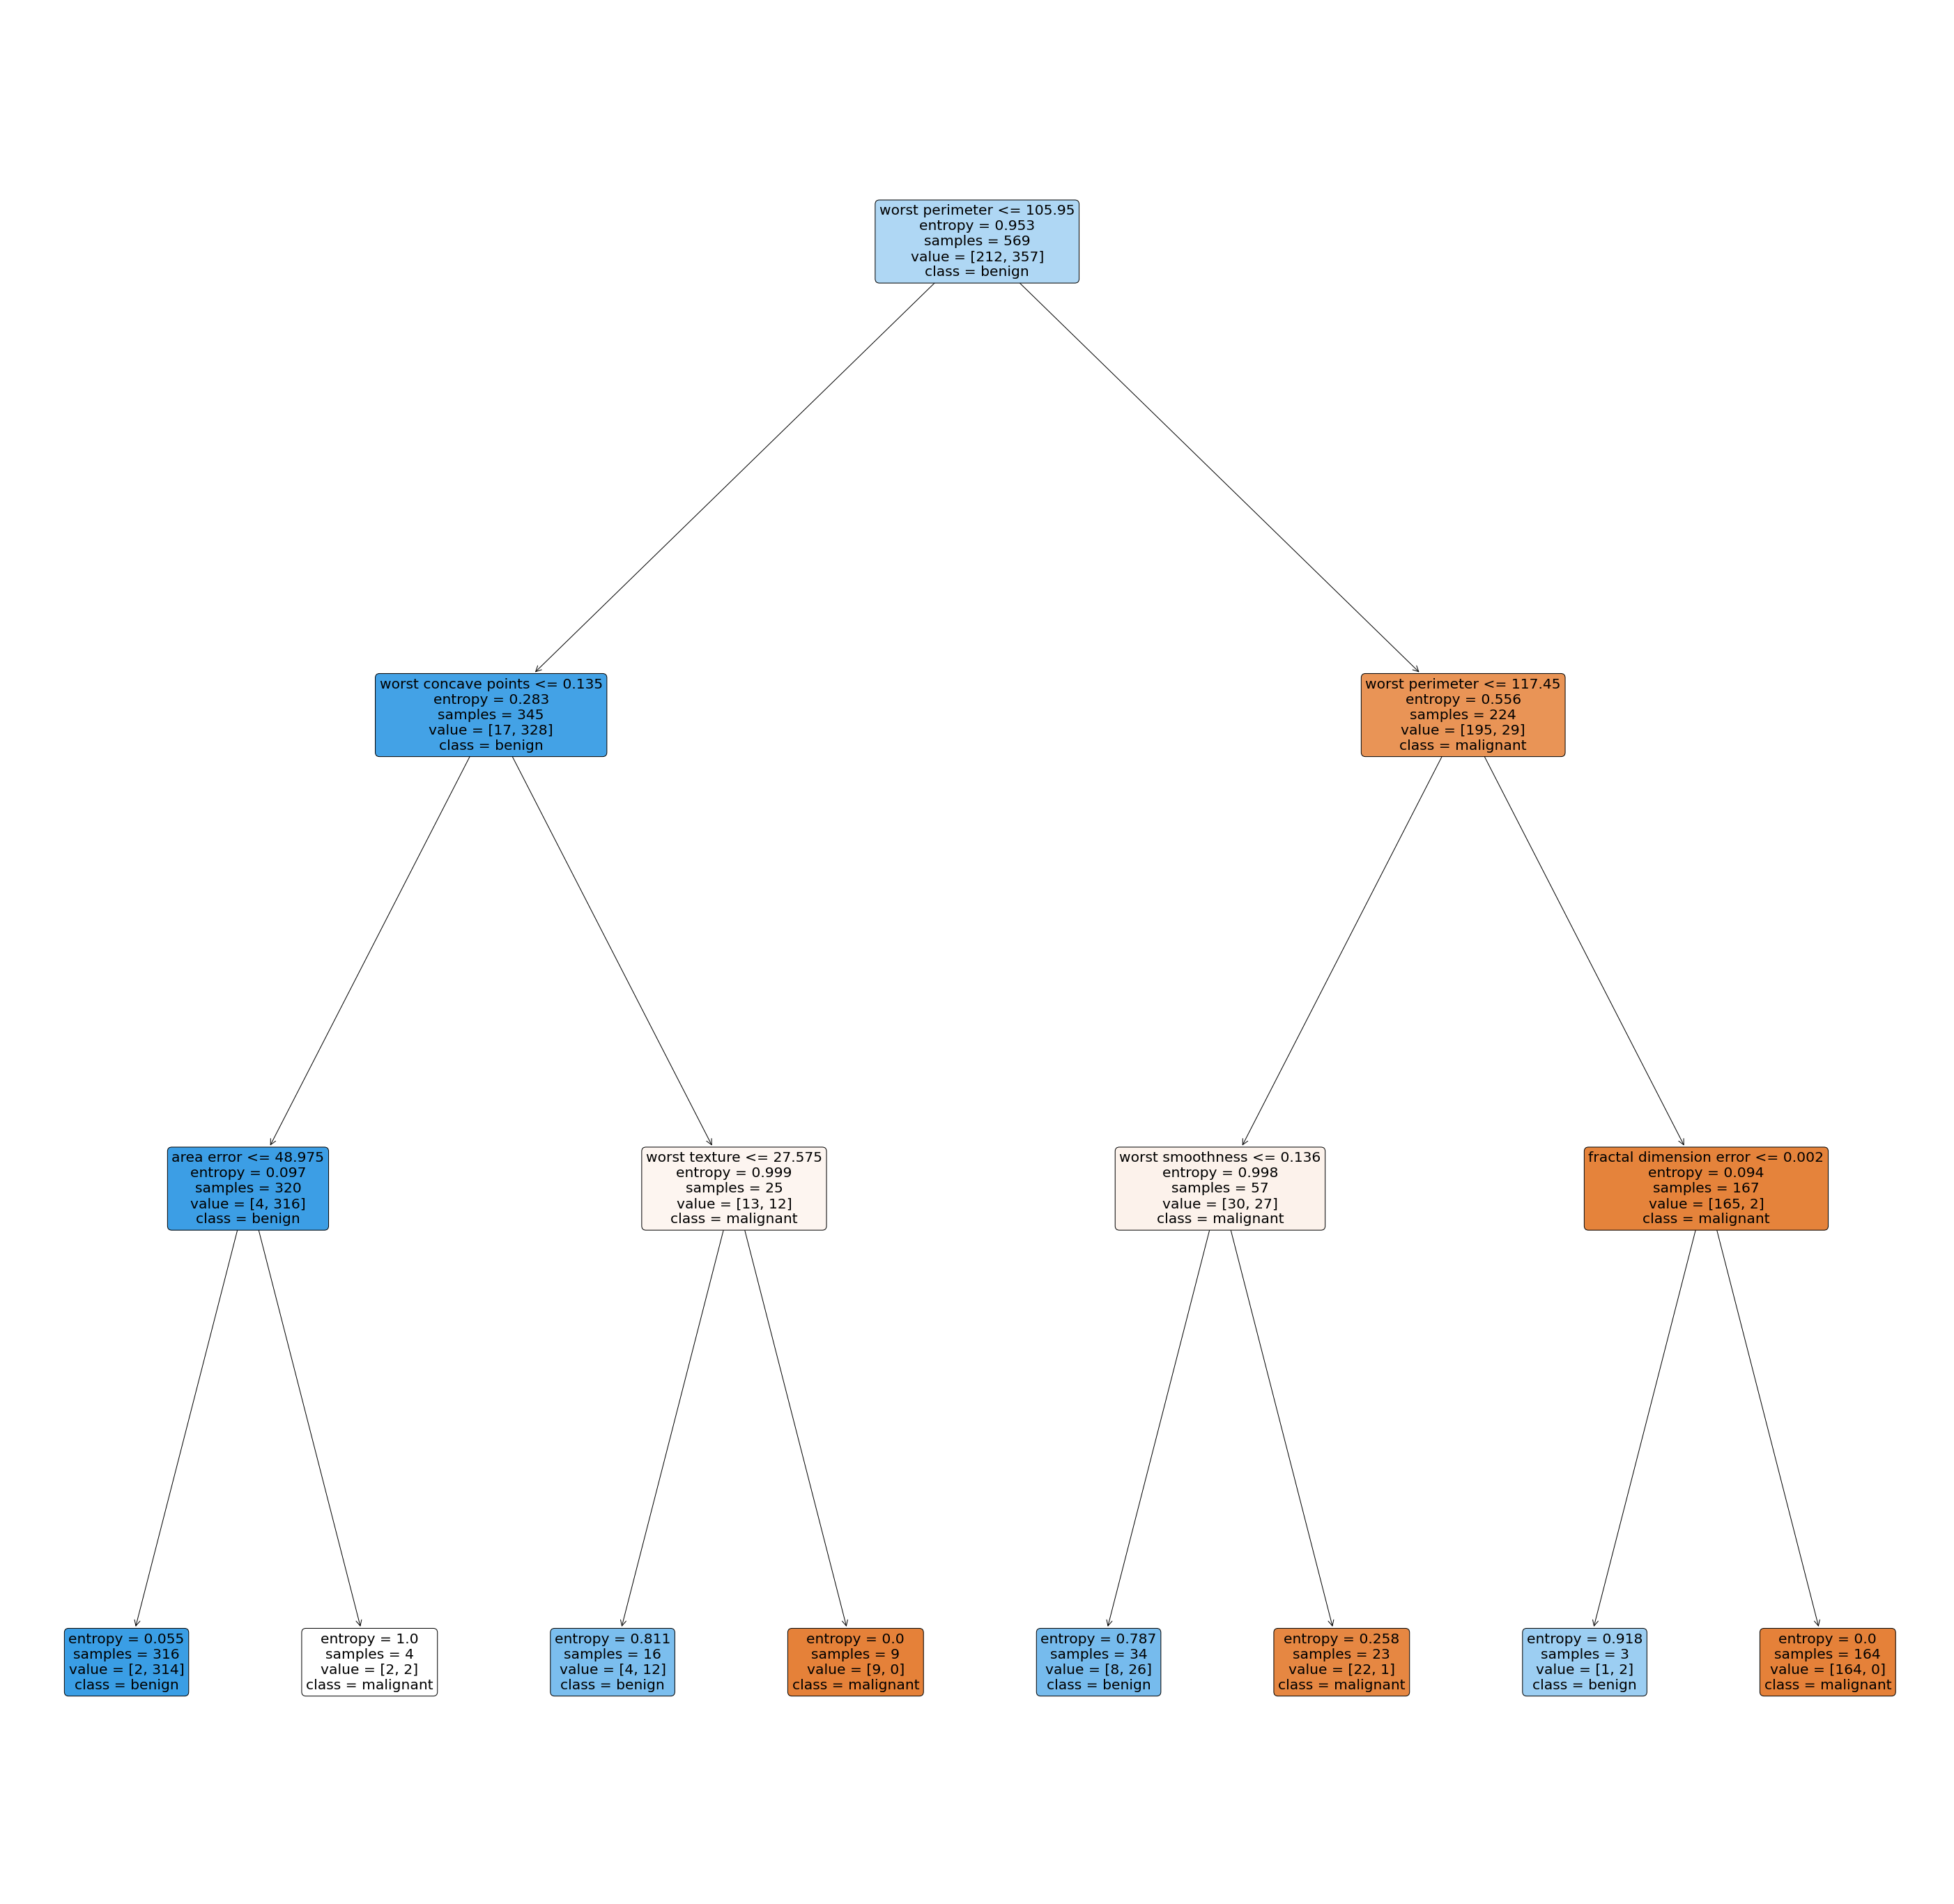

In [403]:
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3, min_samples_split=15, random_state=333)
clf = clf.fit(breast.data, breast.target)
plt.figure(figsize=(50,50))
plot_tree(clf, filled=True, feature_names=breast.feature_names, class_names=breast.target_names, rounded=True)
plt.show()

En base a los resultados del árbol podemos ver que nos clasifica mejor los tumores malignos que los benignos, pero en general, la separación de los individuos de la muestra es bastante aceptable (se explicará más detalladamente cuando analicemos la precisión y el recall).<br><br>
La primera "pregunta" del árbol de decisión es el "worst perimeter", con lo cual el valor extremo del perímetro es la característica que más nos separa los individuos según la naturaleza del tumor. Esta primera separación tiene sentido, ya que un tumor maligno ocasionaría que el pecho estuviese abultado en una zona en concreto. Que haya un valor muy grande del perímetro en un punto en específico no implica que haya un tumor maligno, pero nos da una indicación de que podría haberlo con bastante probabilidad.<br><br>
Las variables con más poder discriminante son aquellas que se ultilizan en los nodos más altos (nos dejan una menor entropía para un conjunto grande de datos). Las variables más discriminantes en este caso serían "worst perimeter" y "worst concave points" las cuales nos dividen muy bien un conjunto grande de datos y dejan nodos con entropía muy baja (o en su defecto con un número de elementos muy pequeño en un nodo, en cuyo caso la entropía no es demasiado representativa al ser un conjunto de individuos muy pequeño)<br><br>
En el árbol hay muchas variables que no han sido utilizadas. Los valores medios no se usan y la desviación se utiliza  muy poco y no nos separa demasiado bien a los individuos (lo cual puede indicar que los tumores modifican una parte específica del pecho y no este en conjunto).<br><br>
Los nodos con mayor confusión son aquellos que o bien tienen muy pocos elementos (los cuales no nos interesan mucho) y aquellos en los que la pregunta para dividir el nodo ha sido una acerca de la desviación, ya que nos separan muy pocos elementos con respecto al nodo padre y puede que solo hayan sido útiles en este caso concreto, con lo cual se podría incluso ignorar dichos nodos hijo y quedarse con el nodo padre.

## Árbol con sobreaprendizaje

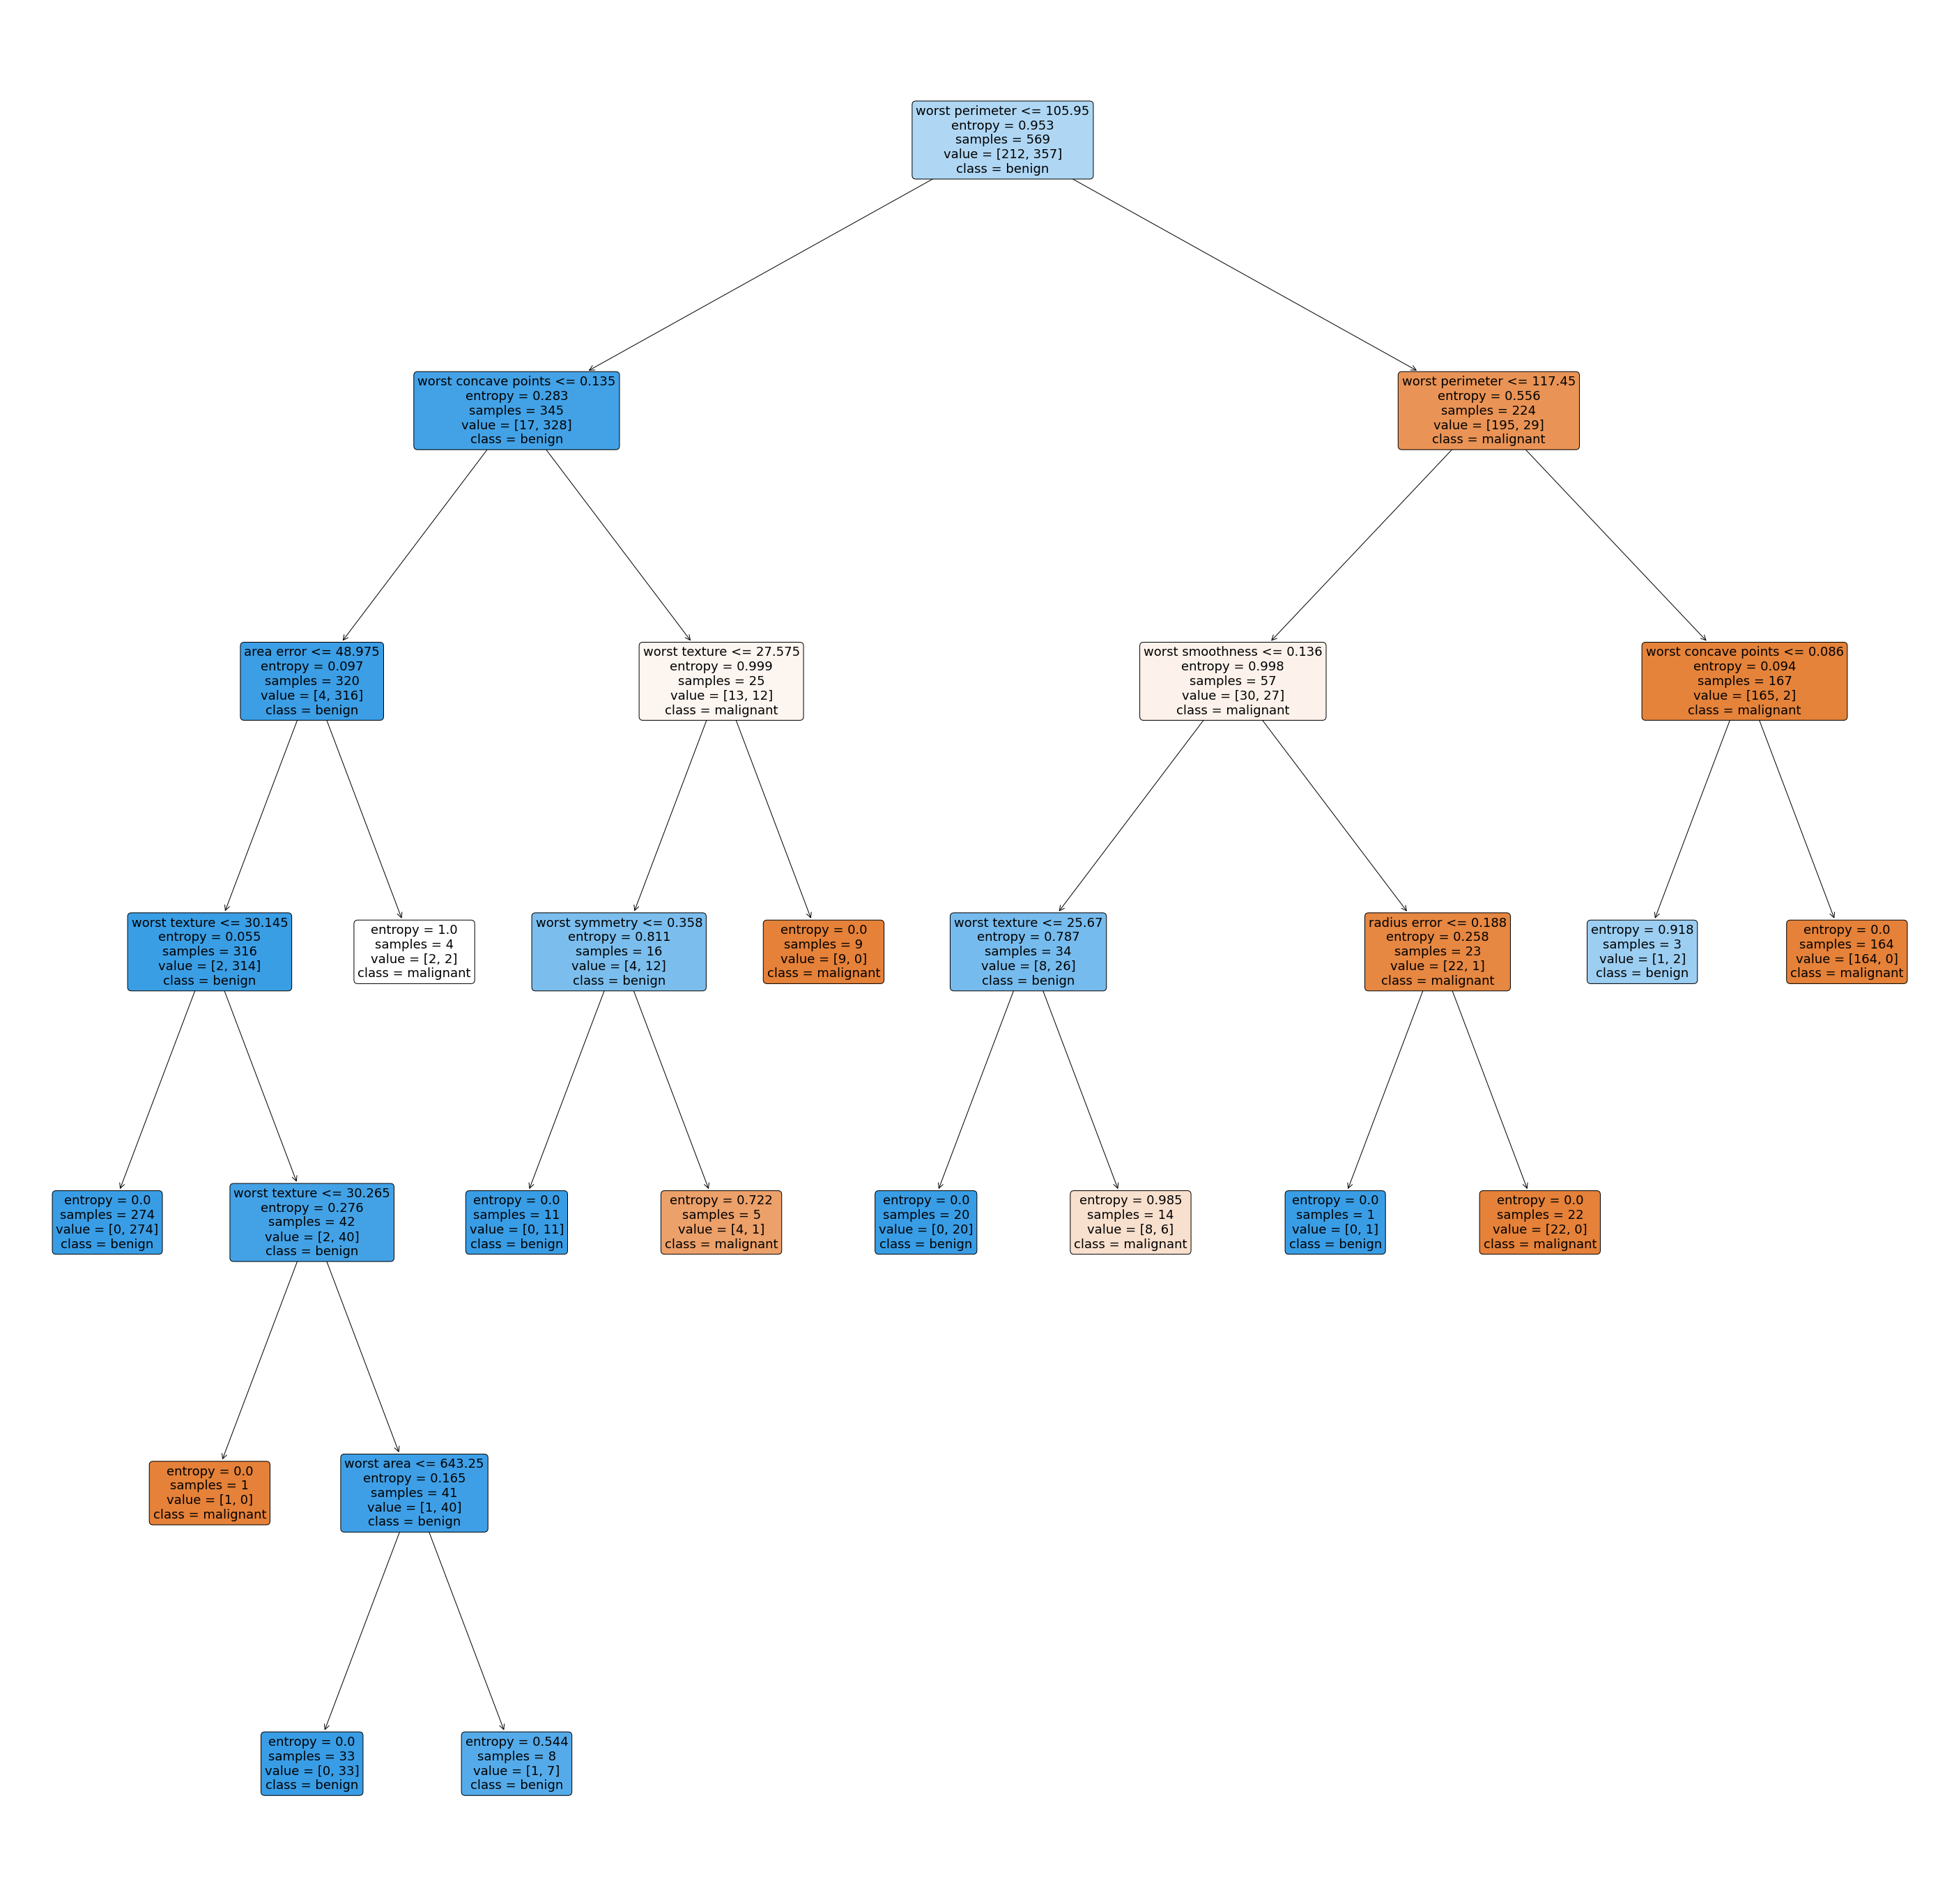

In [405]:
clf_subopt = DecisionTreeClassifier(criterion="entropy", max_depth=6, min_samples_split=15, random_state=333)
clf_subopt = clf_subopt.fit(breast.data, breast.target)
plt.figure(figsize=(50,50))
plot_tree(clf_subopt, filled=True, feature_names=breast.feature_names, class_names=breast.target_names, rounded=True)
plt.show()

Este árbol aunque nos separa mejor los elementos de este conjunto, podemos ver que al dejarle más libertad para seguir expandiendo nodos, aún con la limitación de elementos mínimos para expandirse, es peor que el anterior, ya que hay nodos expandidos que ya tienen un valor de entropía muy bueno, y lo único que se consigue al expandirlos es crear un árbol más complejo y deducir una clasificación para este conjunto de datos en concreto que probablemente no representa el caso real, dado que los elementos que separa en cada nodo llegados un cierto punto están dentro de margen de error.

## Matriz de confusión (árbol óptimo)

In [411]:
from sklearn.model_selection import cross_val_predict

predictions = cross_val_predict(clf, breast.data, breast.target, cv=15)

from sklearn.metrics import classification_report

cr = classification_report(breast.target,predictions, target_names=breast.target_names)

### Mediante una función de sklearn pintamos la matriz de confusión de manera gráfica

In [412]:
# Función extraída de
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
[[0.91037736 0.08962264]
 [0.03921569 0.96078431]]


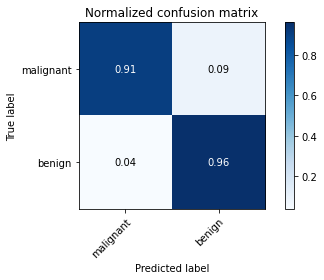

In [413]:
plot_confusion_matrix(breast.target, predictions, breast.target_names, normalize=True)

Representamos los datos de accuracy y recall en forma de texto

In [414]:
print(cr)

              precision    recall  f1-score   support

   malignant       0.93      0.91      0.92       212
      benign       0.95      0.96      0.95       357

    accuracy                           0.94       569
   macro avg       0.94      0.94      0.94       569
weighted avg       0.94      0.94      0.94       569



Como vemos en los datos de la matriz de confusión, tenemos un accuracy del 94% (una precisión del 93% para tumores benignos y una precisión del 95% para los tumores benignos), es decir, acertamos en un 94% de las predicciones.<br>Conseguimos un recall de tumores malignos de 91% (predecimos como malignos un 91% de los tumores malignos totales) y un recall de tumores benignos de 96% (predecimos como benignos un 96% de los tumores benignos totales).

## Clasificador k-NN

Con los parámetros seleccionados según las clases que mejor separan los datos (deducidos de la representación visual, pero no tienen por que ser los óptimos) realizamos en clasificador. Es importante realizar un escalado de los datos, ya que en k-NN si encontramos una característica que en comparación al resto es mucho mayor, el algoritmo de k-NN le dará mayor peso aunque sea una muy mala decisión para separar los datos.

In [415]:
from sklearn.preprocessing import StandardScaler

data_simplified = []

#Cogemos los parametros[worst perimeter, worst concave points, worst texture, worst smoothness]
for b in range(0,569):
    data_simplified.append(breast.data[b][[21,22,24,27]])

scaler = StandardScaler()
scaler.fit(data_simplified)
breast_scaled=scaler.transform(data_simplified)

Configuramos el clasificador para empezar con 8 puntos aleatorios inicialmente y realizar los NN para un rango de 1 a 18 y analizamos los resultados.

In [429]:
skf = neighbors.KNeighborsClassifier(k, weights='distance', p=2)
skf = skf.fit(X_train, y_train)

train_accuracy = skf.score(X_train, y_train)
test_accuracy = skf.score(X_test, y_test)
train_accuracy, test_accuracy

(1.0, 0.9295774647887324)

In [433]:
from sklearn.model_selection import StratifiedKFold
from sklearn import neighbors

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=333)


train_k_results_mean=[]
train_k_results_std=[]
test_k_results_mean=[]
test_k_results_std=[]

rango_k=range(1,18)

k_values=rango_k

for k in rango_k: 
    clf = neighbors.KNeighborsClassifier(k, weights='distance', p=2)
    
    train_results=[]
    test_results=[]
    
    for train_index, test_index in skf.split(breast_scaled, breast.target):
        
        X_train, X_test = breast_scaled[train_index], breast_scaled[test_index]
        y_train, y_test = breast.target[train_index], breast.target[test_index]
        
        clf.fit(X_train, y_train)
        
        train_results.append(clf.score(X_train, y_train))
        test_results.append(clf.score(X_test, y_test))
    
    
    train_k_results_mean.append(np.mean(train_results))
    train_k_results_std.append(np.std(train_results))
    test_k_results_mean.append(np.mean(test_results))
    test_k_results_std.append(np.std(test_results))

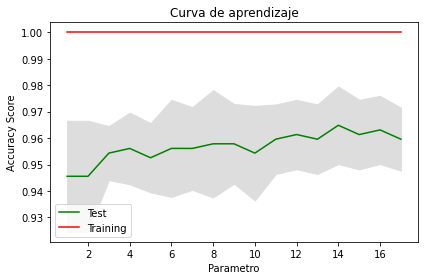

In [434]:
plt.plot(k_values, test_k_results_mean, color="g", label="Test")
plt.plot(k_values, train_k_results_mean, color="r",  label="Training")

lower_limit=np.array(test_k_results_mean)-np.array(test_k_results_std)
upper_limit=np.array(test_k_results_mean)+np.array(test_k_results_std)
plt.fill_between(k_values, lower_limit, upper_limit, color="#DDDDDD")

plt.title("Curva de aprendizaje")
plt.xlabel("Parametro"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

Como vemos la mejor configuración es coger 4-NN ya que es un número pequeño y no nos requerira una capacidad ni un tiempo de computo demasiado grande, es un valor bastante grande en comparación al resto y además la desviación típica de los valores es bastante ajustada, con lo cual, no nos planteamos ninguna otra configuración de k.

In [419]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate

In [435]:
scoring_metrics = ['precision_weighted', 'recall_weighted','f1_weighted']
clf = neighbors.KNeighborsClassifier(4, weights='distance', p=2)
scores = cross_validate(clf, breast_scaled, breast.target, scoring=scoring_metrics, cv=8, return_train_score=False)

print('Precisión ponderada media: ',np.mean(scores['test_precision_weighted']))
print('Exhaustividad ponderada media: ',np.mean(scores['test_recall_weighted']))
print('F1 ponderado media: ',np.mean(scores['test_f1_weighted']))

Precisión ponderada media:  0.9557823664892159
Exhaustividad ponderada media:  0.9542742566510173
F1 ponderado media:  0.9542188237090656


Normalized confusion matrix
[[0.92924528 0.07075472]
 [0.03081232 0.96918768]]


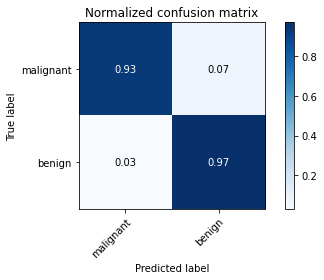

In [424]:
plot_confusion_matrix(breast.target,predictions, normalize=True, classes=breast.target_names)

In [436]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report

predictions = cross_val_predict(clf, breast_scaled, breast.target, cv=8)
cr = classification_report(breast.target,predictions, target_names=breast.target_names)

print(cr)

              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94       212
      benign       0.96      0.97      0.96       357

    accuracy                           0.95       569
   macro avg       0.95      0.95      0.95       569
weighted avg       0.95      0.95      0.95       569



Como vemos en los datos de la matriz de confusión, tenemos un accuracy del 95.5% (una precisión del 95% para tumores benignos y una precisión del 96% para los tumores benignos), es decir, acertamos en un 95.5% de las predicciones.<br>Conseguimos un recall de tumores malignos de 93% (predecimos como malignos un 93% de los tumores malignos totales) y un recall de tumores benignos de 97% (predecimos como benignos un 97% de los tumores benignos totales).